## scikit-learn sample_weight compliance investigative plots

This notebook runs compliance tests on a given scikit-learn estimators. This allows one to plot different features of the resulting predictions and scores with and without weights, so as to check weighted-repeated equivalence.

In [1]:
import sklearn
import threadpoolctl

# HistGradientBoostingClassifier trashes the OpenMP thread pool on repeated
# small fits.
_ = threadpoolctl.threadpool_limits(limits=1, user_api="openmp")

sklearn.show_versions()

meson-python: building scikit-learn: /Users/shrutinath/micromamba/envs/scikit-learn/bin/ninja
[0/1] Regenerating build files.
The Meson build system
Version: 1.4.1
Source dir: /Users/shrutinath/sklearn-dev/scikit-learn
Build dir: /Users/shrutinath/sklearn-dev/scikit-learn/build/cp312
Build type: native build
Project name: scikit-learn
Project version: 1.8.dev0
C compiler for the host machine: /usr/bin/clang (clang 15.0.0 "Apple clang version 15.0.0 (clang-1500.3.9.4)")
C linker for the host machine: /usr/bin/clang ld64 1053.12
C++ compiler for the host machine: /usr/bin/clang++ (clang 15.0.0 "Apple clang version 15.0.0 (clang-1500.3.9.4)")
C++ linker for the host machine: /usr/bin/clang++ ld64 1053.12
Cython compiler for the host machine: cython (cython 3.0.10)
Host machine cpu family: aarch64
Host machine cpu: aarch64
Compiler for C supports arguments -Wno-unused-but-set-variable: YES (cached)
Compiler for C supports arguments -Wno-unused-function: YES (cached)
Compiler for C supports

ninja: error: rebuilding 'build.ninja': subcommand failed



System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:13:44) [Clang 16.0.6 ]
executable: /Users/shrutinath/micromamba/envs/scikit-learn/bin/python
   machine: macOS-14.3-arm64-arm-64bit

Python dependencies:
      sklearn: 1.8.dev0
          pip: 24.0
   setuptools: 75.8.0
        numpy: 2.0.0
        scipy: 1.15.3
       Cython: 3.0.10
       pandas: 2.2.2
   matplotlib: 3.9.0
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 8
         prefix: libopenblas
       filepath: /Users/shrutinath/micromamba/envs/scikit-learn/lib/libopenblas.0.dylib
        version: 0.3.27
threading_layer: openmp
   architecture: VORTEX

       user_api: openmp
   internal_api: openmp
    num_threads: 1
         prefix: libomp
       filepath: /Users/shrutinath/micromamba/envs/scikit-learn/lib/libomp.dylib
        version: None


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sample_weight_audit import check_weighted_repeated_estimator_fit_equivalence
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Note: strong regularization (low C value) makes LogisticRegression
# predictions sensitive to number of data points: this can be a problem when
# used in conjunction with BaggingClassifier, which resamples for a given
# number of data points, that can be defined either as a fraction of the
# training set or as an absolute number.
# solver = "saga"  # stochastic, but does not converge for small C values.
solver = "lbfgs"  # deterministic and stable on this dataset.
estimator = LogisticRegression(C=1e-3, solver=solver, max_iter=1_000)
# estimator = DecisionTreeClassifier(max_depth=5)

# max_samples = 1.0  # relative number of data points to resample during bagging.
max_samples = 100  # absolute number of data points to resample during bagging.
estimator = BaggingClassifier(estimator, n_estimators=30, max_samples=max_samples)
estimator_name = estimator.__class__.__name__

result = check_weighted_repeated_estimator_fit_equivalence(
    estimator,
    estimator_name,
    test_name="kstest",
    n_stochastic_fits=100,
    n_samples_per_cv_group=300,
    store_estimators=True,
    random_state=0,
)

100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


In [7]:
result.to_dict()['estimators_weighted']

[BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=0),
 BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=1),
 BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=2),
 BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=3),
 BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=4),
 BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=5),
 BaggingClassifier(estimator=LogisticRegression(C=0.001, max_iter=1000),
                   max_samples=100, n_estimators=30, random_state=6),

# Make plots of scores

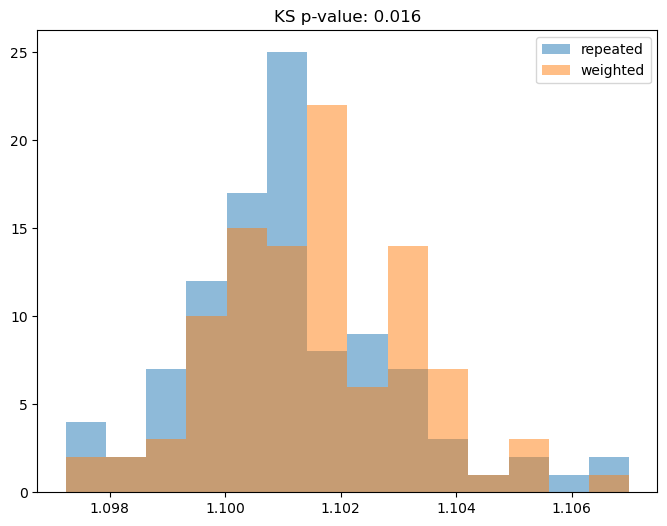

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

alpha = 0.5
eps = 1e-6
min_score = min(result.scores_repeated.min(), result.scores_weighted.min())
max_score = max(result.scores_repeated.max(), result.scores_weighted.max())
if max_score - min_score < eps:
    min_score -= eps
    max_score += eps

bins_scores = np.linspace(min_score, max_score, 15)
ax.hist(result.scores_repeated, alpha=alpha, bins=bins_scores, label="repeated")
ax.hist(result.scores_weighted, alpha=alpha, bins=bins_scores, label="weighted")
ax.legend()
_ = ax.set_title(f"KS p-value: {result.pvalue:.2g}")

# Make plots of predictions

## Plot the histograms of predictions for some randomly selected test points

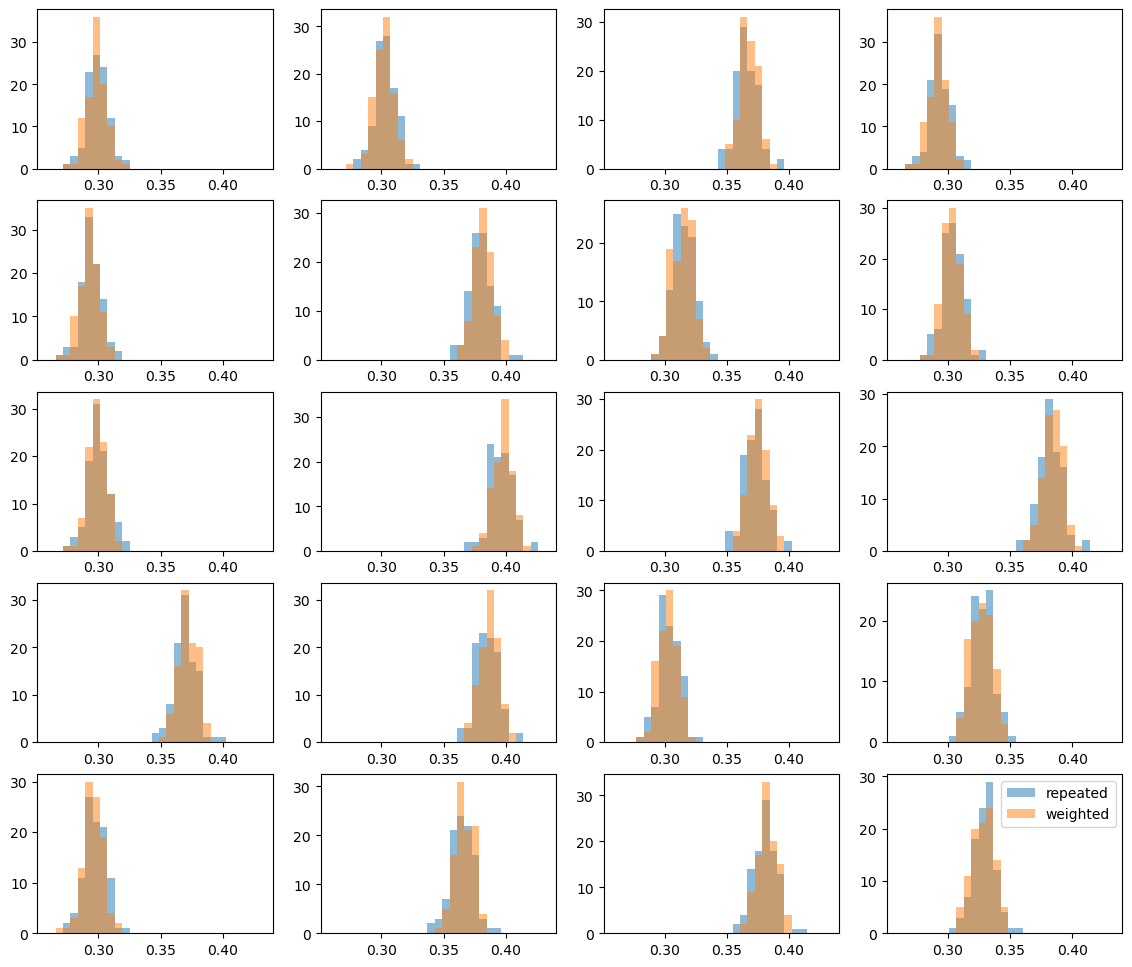

In [10]:
fig, axs = plt.subplots(5, 4, figsize=(14, 12))
n_plots = len(axs.flatten())

rng = np.random.default_rng(0)
sample_indices = rng.choice(
    np.arange(result.predictions_weighted.shape[1]), size=n_plots, replace=False
)

min_prediction = min(
    result.predictions_repeated.min(), result.predictions_weighted.min()
)
max_prediction = max(
    result.predictions_repeated.max(), result.predictions_weighted.max()
)
if max_prediction - min_prediction < eps:
    min_prediction -= eps
    max_prediction += eps
bins_predictions = np.linspace(min_prediction, max_prediction, 30)

for sample_idx, ax in zip(sample_indices, axs.flatten()):
    ax.hist(
        result.predictions_repeated[:, sample_idx].flatten(),
        alpha=alpha,
        bins=bins_predictions,
        label="repeated",
    )
    ax.hist(
        result.predictions_weighted[:, sample_idx].flatten(),
        alpha=alpha,
        bins=bins_predictions,
        label="weighted",
    )

# Show the legend only on the last subplot
_ = ax.legend()


## Zooming into individual samples

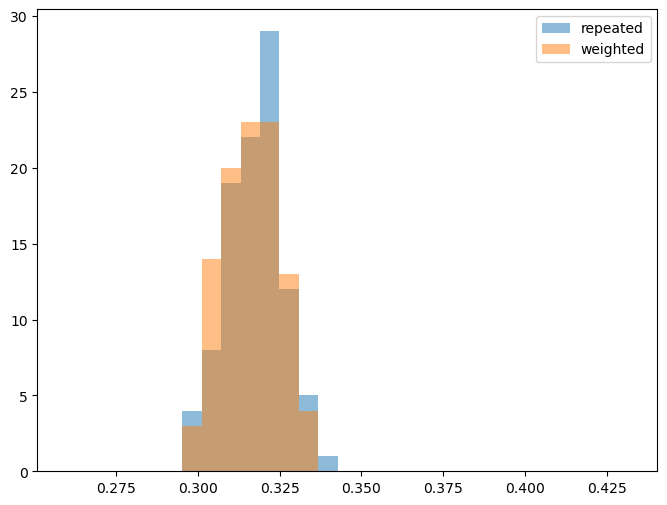

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8, 6))

sample_idx = 50
ax.hist(result.predictions_repeated[:, sample_idx].flatten(), alpha=alpha, bins=bins_predictions, label='repeated')
ax.hist(result.predictions_weighted[:, sample_idx].flatten(), alpha=alpha, bins=bins_predictions, label='weighted')
_ = ax.legend()